## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
# import torch.onnx

from relaynet_pytorch.relay_net import ReLayNet
from relaynet_pytorch.data_utils import get_imdb_data

# from networks.relay_net import ReLayNet
#from networks.data_utils import get_imdb_data

#torch.set_default_tensor_type('torch.FloatTensor')

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
import os
cwd = os.getcwd()

## Read in Model

First Line below removes warnings from ReLayNet

In [3]:
%%capture --no-stdout 
## My adapted code
from torch.utils.serialization import load_lua
model = cwd + '/models/Exp01/relaynet_epoch20.model'
# model = cwd + '/models/relaynet_good.model'

# load the model
relaynet_model = torch.load(model).cuda()

In [4]:
# Printing the test data and the weights for the layers out
# relaynet_model # architecture of the net
# relaynet_model.eval()

In [5]:
# list(relaynet_model.encode1.parameters()) # weights on certain layers

In [6]:
# Printing model weights
# w = list(relaynet_model.parameters())
# w
# for param in relaynet_model.parameters():
#   print(param.data)
# list(relaynet_model.parameters()) # all weights

In [7]:
# print(torch.__version__)
# torch.cuda.FloatTensor(10)

## Load Image

In [9]:
# file = '/datasets/ResizedImages'
file = '/datasets/DenoiseImages/DenoisedTrainImages/denoised_5.png'
# file = '/datasets/con_H1_N01848_LV_1_194.tif'
# file = '/datasets/con_H1_N01848_LA_1_272.tif'
# file = '/datasets/con_H1_N01848_LA_1_272_denoised.png'
# file = '/datasets/test_image.png'

directory = cwd + file

# # Seeing whether file exists
image = plt.imread(directory)

test_data = image
test_data.shape
# # test_data = test_data[:,:,0]

(216, 64)

In [ ]:
plt.imshow(test_data,cmap = "gray")

# Helper Functions

In [11]:
import torch.nn.functional as F

#### All divisors

In [12]:
import math

def divisorGenerator(n):
    large_divisors = []
    for i in range(1, int(math.sqrt(n) + 1)):
        if n % i == 0:
            yield i
            if i*i != n:
                large_divisors.append(n / i)
    for divisor in reversed(large_divisors):
        yield divisor

#### Coloured Labelling

In [13]:
SEG_LABELS_LIST = [
    {"id": -1, "name": "void", "rgb_values": [0, 0, 0]},
    {"id": 0, "name": "Region above the retina (RaR)", "rgb_values": [128, 0, 0]},
    {"id": 1, "name": "ILM: Inner limiting membrane", "rgb_values": [0, 128, 0]},
    {"id": 2, "name": "NFL-IPL: Nerve fiber ending to Inner plexiform layer", "rgb_values": [128, 128, 0]},
    {"id": 3, "name": "INL: Inner Nuclear layer", "rgb_values": [0, 0, 128]},
    {"id": 4, "name": "OPL: Outer plexiform layer", "rgb_values": [128, 0, 128]},
    {"id": 5, "name": "ONL-ISM: Outer Nuclear layer to Inner segment myeloid", "rgb_values": [0, 128, 128]},
    {"id": 6, "name": "ISE: Inner segment ellipsoid", "rgb_values": [128, 128, 128]},
    {"id": 7, "name": "OS-RPE: Outer segment to Retinal pigment epithelium", "rgb_values": [64, 0, 0]},
    {"id": 8, "name": "Region below RPE (RbR)", "rgb_values": [192, 0, 0]}];
    #{"id": 9, "name": "Fluid region", "rgb_values": [64, 128, 0]}];
    
def label_img_to_rgb(label_img):
    label_img = np.squeeze(label_img)
    labels = np.unique(label_img)
    label_infos = [l for l in SEG_LABELS_LIST if l['id'] in labels]

    label_img_rgb = np.array([label_img,
                              label_img,
                              label_img]).transpose(1,2,0)
    for l in label_infos:
        mask = label_img == l['id']
        label_img_rgb[mask] = l['rgb_values']

    return label_img_rgb.astype(np.uint8)

#### Show Images

In [14]:
def show_image(idxs):
    idxs = idxs.data.cpu().numpy()
    idxs = label_img_to_rgb(idxs)
    plt.imshow(idxs)
    plt.show()

def show_main_image(img_data):
    img_data = np.squeeze(img_data) # we do squeeze image test to remove any additional unwanted dimensions.
    plt.imshow(img_data)
    plt.show()

#### O/P of ReLayNet Classification

In [15]:
def relay_out(test_data):
    out = relaynet_model(Variable(torch.cuda.FloatTensor(test_data)))
    out = F.softmax(out,dim=1)
    max_val, idx = torch.max(out,1) # torch.max(input, dim, keepdim=False, out=None) -> (Tensor, LongTensor)
    return max_val, idx

#### Sliding window function to segment certain parts of image

In [16]:
# Source: https://web.archive.org/web/20170223091206/http://www.johnvinyard.com/blog/?p=268
# Source: https://stackoverflow.com/questions/22685274/divide-an-image-into-5x5-blocks-in-python-and-compute-histogram-for-each-block
from numpy.lib.stride_tricks import as_strided as ast
from itertools import product

def norm_shape(shape):
    '''
    Normalize numpy array shapes so they're always expressed as a tuple, 
    even for one-dimensional shapes.

    Parameters
        shape - an int, or a tuple of ints

    Returns
        a shape tuple
    '''
    try:
        i = int(shape)
        return (i,)
    except TypeError:
        # shape was not a number
        pass

    try:
        t = tuple(shape)
        return t
    except TypeError:
        # shape was not iterable
        pass

    raise TypeError('shape must be an int, or a tuple of ints')

def sliding_window(a,ws,ss = None,flatten = False):
    '''
    Return a sliding window over a in any number of dimensions
     
    Parameters:
        a  - an n-dimensional numpy array
        ws - an int (a is 1D) or tuple (a is 2D or greater) representing the size 
             of each dimension of the window
        ss - an int (a is 1D) or tuple (a is 2D or greater) representing the 
             amount to slide the window in each dimension. If not specified, it
             defaults to ws.
        flatten - if True, all slices are flattened, otherwise, there is an 
                  extra dimension for each dimension of the input.
     
    Returns
        an array containing each n-dimensional window from a
    '''
     
    if None is ss:
        # ss was not provided. the windows will not overlap in any direction.
        ss = ws
    ws = norm_shape(ws)
    ss = norm_shape(ss)
     
    # convert ws, ss, and a.shape to numpy arrays so that we can do math in every 
    # dimension at once.
    ws = np.array(ws)
    ss = np.array(ss)
    shape = np.array(a.shape)
     
     
    # ensure that ws, ss, and a.shape all have the same number of dimensions
    ls = [len(shape),len(ws),len(ss)]
    if 1 != len(set(ls)):
        raise ValueError(\
        'a.shape, ws and ss must all have the same length. They were %s' % str(ls))
     
    # ensure that ws is smaller than a in every dimension
    if np.any(ws > shape):
        raise ValueError(\
        'ws cannot be larger than a in any dimension.\
 a.shape was %s and ws was %s' % (str(a.shape),str(ws)))
     
    # how many slices will there be in each dimension?
    newshape = norm_shape(((shape - ws) // ss) + 1)
    # the shape of the strided array will be the number of slices in each dimension
    # plus the shape of the window (tuple addition)
    newshape += norm_shape(ws)
    # the strides tuple will be the array's strides multiplied by step size, plus
    # the array's strides (tuple addition)
    newstrides = norm_shape(np.array(a.strides) * ss) + a.strides
    strided = ast(a,shape = newshape,strides = newstrides)
    if not flatten:
        return strided
     
    # Collapse strided so that it has one more dimension than the window.  I.e.,
    # the new array is a flat list of slices.
    meat = len(ws) if ws.shape else 0
    firstdim = (np.product(newshape[:-meat]),) if ws.shape else ()
    dim = firstdim + (newshape[-meat:])
    # remove any dimensions with size 1
#     dim = filter(lambda i : i != 1,dim)
    dim = list(filter(lambda i : i != 1,dim))
    return strided.reshape(dim)

# How to use sliding window function above
# rows = 512
# columns = 600
# divisor = 54
# col_size, col_overlap = divmod(columns, divisor)
# row_size, row_overlap = divmod(rows, divisor)
# ws = (row_size, col_size)
# ss = (row_size - row_overlap, col_size - col_overlap)

#### Segment Data

In [17]:
def segment(test_data, x, y):
    '''
    Takes data, width and height and returns list of images that can be classified individually
    
    X dimension has to be multiples of 8 because sizes of tensors must match except in dimension 1.
    '''
    seg_images_list = [] # list of segmented images
    x_init_val = 0
    y_init_val = 0
    height, width = test_data.shape
#     print(x_init_val)
#     print(height,width)
    for i in range(x,width,x):
#         print("in loop")
#         print("Initial x: {}, i:{}, x:{}".format(x_init_val, i, x))
        segmented_data = test_data[:,x_init_val:i] # split data
        segmented_data.shape = (1,1,y,x)
        seg_images_list.append(segmented_data)
        x_init_val += x
#     for i, j in zip(range(x,width,x), range(y,height,y)):
#         print("in loop")
#         print("Initial y: {}, j:{}, y:{}".format(y_init_val, j, y))
#         print("Initial x: {}, i:{}, x:{}".format(x_init_val, i, x))
#         segmented_data = test_data[y_init_val:y, x_init_val:i] # split data 
#         segmented_data.shape = (1,1,y,x)
#         seg_images_list.append(segmented_data)
#         x_init_val += x
#         y_init_val += x
#     out_seg = relay_out(new_test)
    
    return segmented_data

## Data types

##### Testing data Dimensions

In [112]:
# X = np.zeros((512,600)) # create numpy array of size 512 x 600
# data = np.array([[11, 22, 33, 44, 55],[2,3,4,5,6],[10,20,30,40,50]])
# print(data[:,0])
# print(type(test_data))
# print(test_data.shape)
# print(test_data.dtype)
# new_test_data = np.zeros((512,600))

##### Data input

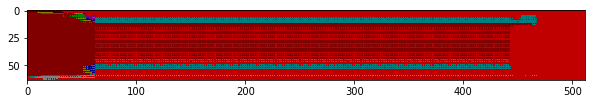

In [22]:
# Dummy Input
# Input is organised [No., Channel, Width, Height] - [1,1,64,512]
# Float tensor because weights are float Tensors

dummy_input = Variable(torch.cuda.FloatTensor(1,1,64,512)) # has to be (1,1,...) because the first is no. therefore can't plot 2d image on same plot.
# print(dummy_input)
# Getting ReLayNet max_val, idx classification values
max_val_trans, idx_trans = relay_out(dummy_input)

# Test image
show_image(idx_trans)

# new_test = np.transpose(new_test, (0, 1, 3, 2)) # Transposing changes rotation of image

# Deploy Model on Test Data

## Different Size Segmentation

In [114]:
seg_test = np.copy(test_data) # Copy so it doesn't alter init dimensions of test_data
# seg_test.shape = (1,1,512,600) # Change dimensions of data

# new_test = np.transpose(new_test, (0, 1, 3, 2)) # Transposing - changes rotation of image

# Getting ReLayNet max_val, idx classification values
# max_val_trans, idx_trans = relay_out(new_test)

# Test image
# show_image(idx_trans)

# Main Image
# img_test = np.transpose(test_data, (1,0)) # transpose as changes direction of image 
# show_main_image(img_test)

In [122]:
# # How to use sliding window function above
# height, width = test_data.shape
# rows = height # height
# columns = width # width
# divisor = 4
# col_size, col_overlap = divmod(columns, divisor)
# row_size, row_overlap = divmod(rows, divisor)
# ws = (row_size, col_size)
# ss = (row_size - row_overlap, col_size - col_overlap)
# # calling sliding window function to return 
# arrays = sliding_window(test_data, ws, ss)
# print(ws,ss)
# a1 = arrays[1]
# print(a1.shape)
# byte, h1,w1 = a1.shape
# rows = h1 # height
# columns = w1 # width
# divisor = 2
# col_size, col_overlap = divmod(columns, divisor)
# row_size, row_overlap = divmod(rows, divisor)
# ws = (row_size, col_size)
# ss = (row_size - row_overlap, col_size - col_overlap)
# print(ws,ss)
# a1.reshape(1,1,64,75)
# a1.shape = (1,1,h1,w1)
# print(a1.shape)
# out_eg = relay_out(a1)

## Transpose vs Not Transpose

### Transpose

In [159]:
from torchvision.datasets import ImageFolder
from torchvision import transforms, datasets

In [ ]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
#         self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:].as_matrix()
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [181]:
# Load mutiple images in - https://medium.com/@yvanscher/pytorch-tip-yielding-image-sizes-6a776eb4115b
transform = transforms.Compose([
    # you can add other transformations in this list
    transforms.ToTensor()
])
data = ImageFolder('/home/sim/notebooks/relaynet_pytorch/datasets/OCTlabel041818', transform)
data_loader = torch.utils.data.DataLoader(dataset=data,
                             batch_size=1,
                             shuffle=False,
                             num_workers=1)


for batch in data_loader:
    print(batch[0].size())

torch.Size([1, 3, 512, 600])
torch.Size([1, 3, 512, 600])
torch.Size([1, 3, 512, 600])
torch.Size([1, 3, 512, 600])
torch.Size([1, 3, 512, 600])
torch.Size([1, 3, 512, 600])
torch.Size([1, 3, 512, 600])
torch.Size([1, 3, 512, 600])
torch.Size([1, 3, 512, 600])
torch.Size([1, 3, 512, 600])
torch.Size([1, 3, 512, 600])
torch.Size([1, 3, 512, 600])
torch.Size([1, 3, 512, 600])
torch.Size([1, 3, 512, 600])
torch.Size([1, 3, 512, 600])
torch.Size([1, 3, 502, 800])
torch.Size([1, 3, 512, 800])
torch.Size([1, 3, 502, 800])
torch.Size([1, 3, 512, 800])
torch.Size([1, 3, 502, 800])
torch.Size([1, 3, 512, 800])
torch.Size([1, 3, 502, 800])
torch.Size([1, 3, 512, 800])
torch.Size([1, 3, 502, 800])
torch.Size([1, 3, 512, 800])
torch.Size([1, 3, 502, 800])
torch.Size([1, 3, 512, 800])
torch.Size([1, 3, 502, 800])
torch.Size([1, 3, 512, 800])
torch.Size([1, 3, 502, 800])
torch.Size([1, 3, 512, 800])
torch.Size([1, 3, 502, 800])
torch.Size([1, 3, 512, 800])
torch.Size([1, 3, 502, 800])
torch.Size([1,

In [8]:
new_test = np.copy(test_data) # Copy so it doesn't alter init dimensions of test_data

# new_test.shape = (1,1,512,600) # Change dimensions of data
# new_test = new_test[:400,:400]
# new_test.shape = (1,1,400,400)
new_test = np.transpose(new_test, (0, 1, 3, 2)) # Transposing - changes rotation of image

# Getting ReLayNet max_val, idx classification values
max_val_trans, idx_trans = relay_out(new_test)

# Test image
show_image(idx_trans)

# Main Image
img_test = np.transpose(test_data, (1,0)) # transpose as changes direction of image 
show_main_image(img_test)

NameError: name 'test_data' is not defined

### Not Transpose

In [91]:
new_test = np.copy(test_data) # Copy so it doesn't alter init dimensions of test_data
new_test.shape = (1,1,512,600) # Change dimensions of data

# Getting ReLayNet max_val, idx classification values
max_val, idx = relay_out(new_test)

# Test image
show_image(idx)

# Main Image
img_test = test_data
show_main_image(img_test)

ValueError: cannot reshape array of size 763876 into shape (1,1,512,600)

### Export Model
##### Date:  13/07/2018 
Can't export model as MaxPool2d with index output is not supported in ONNX: https://discuss.pytorch.org/t/problems-converting-pytorch-model-into-onnx/12192/3.


In [ ]:
# Removed code from batchnorm.py for all references to track_running_stats - see comments in the code

# relaynet_model.eval()
# dummy_input = Variable(torch.cuda.FloatTensor(1,1,600,64)) # has to be (1,1,...) because the first is no. therefore can't plot 2d image on same plot.
# torch.onnx.export(relaynet_model, dummy_input, "model.onnx", verbose=True)

### Open Matlab Files

In [ ]:
# import scipy.io as sio